In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
# Input vectors x are synthetic data intended to simulate the 
# properties we believe the true underlying features of our task have
# We consider each dimension xi to be a "feature"
# Each one has an associated sparsity Si and importance Ii
# We let xi = 0 with probability Si, but it is otherwise
# uniformly distributed [0,1]
# In practice, we focus on the case where all features have the same
# sparsity, Si = S

In [3]:
# Scratch Work:
# W = torch.randn(10,100) # 100x100 weight matrix
# h = W@x
# x.shape, W.shape, h.shape
# W_l = nn.Linear(100,10)
# h_l = W_l(x.T)
# x.T.shape, W_l.weight.shape, h_l.shape
# Wt = W.T
# W_lt = W_l.weight.T
# b = torch.randn(10)
# x_prime = Wt@h + b
# x_prime_l = W_lt@h_l.T + b
# x_prime.shape, x_prime_l.shape, Wt.shape, W_lt.shape, b.shape

In [4]:
# Generate synthetic X data
num_points = 1
x = torch.rand(num_points,20) # 1 data point, uniformly distributed [0,1]
# Sparsity Vector
sparsity = 0.5 # arbitrary
rand_vec = torch.rand(x.shape)
mask = rand_vec <= sparsity
x[mask] = 0
# Importance vector
i = torch.rand(20)

In [5]:
class SimpleLinear(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, hidden_dim)*0.1) # W = (20,5)

    def forward(self, x):
        h = x @ self.W
        x_prime = h @ self.W.T

        # h = x @ self.W # Down Projection from in -> hidden dimensions
        # x_prime = h @ self.W.T # Projection back to in_dim
        return x_prime
    
    def get_WWt(self):
        return self.W @ self.W.T

In [6]:
# Linear Simple Model
model_simp = SimpleLinear(20,5)
x_prime_simp = model_simp(x)
x_prime_simp.shape

torch.Size([1, 20])

In [25]:
class ReLUModel(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_dim, hidden_dim)*0.1) # W = (20,5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # h = x @ self.W # Down Projection from in -> hidden dimensions
        # x_prime = h @ self.W.T # Projection back to in_dim
        # print(f"W shape: {self.W.shape}")

        h = x @ self.W
        x_prime = h @ self.W.T
        x_prime = self.relu(x_prime)
        return x_prime
    
    def get_WWt(self):
        return self.W @ self.W.T

In [26]:
# Linear Simple Model
model_simp = SimpleLinear(20,5)
x_prime_simp = model_simp(x)
x_prime_simp.shape

torch.Size([1, 20])

In [27]:
# ReLU Model
model_relu = ReLUModel(20,5)
x_prime_relu = model_relu(x)
x_prime_relu.shape

torch.Size([1, 20])

In [28]:
# Losses
mse_loss = nn.MSELoss()
loss_simp = mse_loss(x_prime_simp, x)
loss_relu = mse_loss(x_prime_relu, x)
loss_simp, loss_relu

(tensor(0.0794, grad_fn=<MseLossBackward0>),
 tensor(0.0789, grad_fn=<MseLossBackward0>))

In [29]:
# Importance-Weighted Losses
def weighted_loss(predicted, x, importance):

    squared_errors = (predicted - x)**2
    weighted = importance*squared_errors
    total_loss = torch.sum(weighted)
    return total_loss

In [30]:
def train(model, trainloder, valloader, importance, opt, scheduler, epoch_mod=1, epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # print(f"Epoch: {epoch}")
        model.train()
        epoch_train_loss = 0
        epoch_val_loss = 0

        train_batches = 0
        val_batches = 0

        for x, _ in trainloder:
            optimizer.zero_grad()
            output = model(x)
            loss = weighted_loss(output, x, importance)

            loss.backward()
            opt.step()
            scheduler.step()

            epoch_train_loss += loss.item()
            train_batches += 1

        with torch.no_grad():
            model.eval()
            for xv, _ in valloader:
                val_output = model(xv)
                val_loss = weighted_loss(val_output, xv, importance)
                epoch_val_loss += val_loss.item()
                val_batches += 1

        avg_train_loss = epoch_train_loss / train_batches
        avg_val_loss = epoch_val_loss / val_batches
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        if epoch % epoch_mod == 0:
            print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    return model, train_losses, val_losses


In [31]:
# Generate full X data
num_points = 10000
X_dim = 20
X = torch.rand(num_points,X_dim) # 10000 data points, uniformly distributed [0,1]

# Sparsity Vector
sparsity = 0.5 # arbitrary
rand_vec = torch.rand(X.shape)
mask = rand_vec <= sparsity
X[mask] = 0

# Importance vector
importance = torch.rand(X_dim)

# Train-Val Split
train_ratio = 0.9
n_train = int(num_points*train_ratio)
X_train = X[:n_train]
X_val = X[n_train:]

# DataLoader
batch_size = 32
train_data = TensorDataset(X_train, X_train)
val_data = TensorDataset(X_val, X_val)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [32]:
# Model initialization:
low_dim = 5
model_simp = SimpleLinear(X_dim,low_dim)
model_relu = ReLUModel(X_dim, low_dim)

In [33]:
lr = 0.1
n_params = model_simp.parameters()
optimizer = optim.Adam(n_params, lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

print("Linear Model:")
model_simp_trained, simp_tl, simp_vl = train(model_simp, trainloader, valloader, importance, optimizer, scheduler, epochs=1)
print("ReLU Model:")
model_relu_trained, relu_tl, relu_vl = train(model_relu, trainloader, valloader, importance, optimizer, scheduler, epochs=1)

Linear Model:
Epoch 0: Train Loss = 20.3490, Val Loss = 19.3314
ReLU Model:
Epoch 0: Train Loss = 46.6346, Val Loss = 45.6634


In [34]:
def weight_heatmap(model,cmap='coolwarm', ax=None):
    WtW = model.get_WWt()
    WtW = torch.detach(WtW).numpy()

    if ax is None:
        ax = plt.gca()

    sns.heatmap(WtW, cmap=cmap, ax=ax)
    return ax

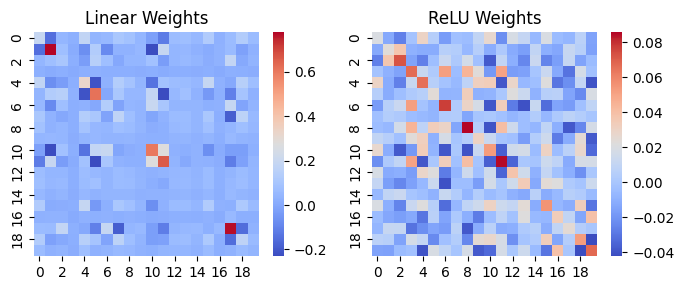

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))

weight_heatmap(model_simp_trained, ax=ax1)
weight_heatmap(model_relu_trained, ax=ax2)

ax1.set_title('Linear Weights')
ax2.set_title('ReLU Weights')

plt.tight_layout()
plt.show() 

In [37]:
torch.max(model_simp_trained.W)

tensor(0.8048, grad_fn=<MaxBackward1>)

In [38]:
torch.max(model_relu_trained.W)

tensor(0.1945, grad_fn=<MaxBackward1>)

In [39]:
def generate_importance_vector(n_features, decay_factor=0.7):

    i_indices = torch.arange(n_features)  # [0, 1, 2, ..., n_features-1]
    importance = decay_factor ** i_indices
    
    return importance

In [41]:
def generate_sparse_data(sparsity, X_dim, num_points, train_ratio, decay, batch_size):

    # Generate full X data
    X = torch.rand(num_points, X_dim) # uniformly distributed [0,1]

    # Sparsity Vector
    rand_vec = torch.rand(X.shape)
    mask = rand_vec <= sparsity
    X[mask] = 0

    # Importance vector
    importance = generate_importance_vector(X_dim, decay)

    # Train-Val Split
    n_train = int(num_points*train_ratio)
    X_train = X[:n_train]
    X_val = X[n_train:]

    # DataLoader
    train_data = TensorDataset(X_train, X_train)
    val_data = TensorDataset(X_val, X_val)
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return X, importance, train_data, val_data, trainloader, valloader

***Linear Model Training***

In [44]:
# Hyperparameters:
low_dim = 5
X_dim = 20
decay = 0.7
num_points = 10000
train_ratio = 0.9
batch_size = 32
lr = 1e-3
n_params = model_simp.parameters()
optimizer = optim.Adam(n_params, lr=lr)

In [51]:
linear_model = SimpleLinear(X_dim, low_dim)

X, imp, train_data, val_data, trainloader, valloader = generate_sparse_data(sparsity, X_dim, num_points, train_ratio, decay, batch_size)

linear_model, linear_tl, linear_vl = train(linear_model, trainloader, valloader, imp, optimizer, scheduler, epochs=20)

torch.save(linear_model.state_dict(), f'saved_models/linear_model.pth')

Epoch 0: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 1: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 2: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 3: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 4: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 5: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 6: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 7: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 8: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 9: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 10: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 11: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 12: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 13: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 14: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 15: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 16: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 17: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 18: Train Loss = 0.0334, Val Loss = 0.0346
Epoch 19: Train Loss = 0.0334, Val Loss = 0.0346


***ReLU Model Training***

In [52]:
sparsity_values = [0, 0.7, 0.9, 0.97, 0.99, 0.997, 0.999]

relu_model0 = ReLUModel(X_dim, low_dim)
relu_model1 = ReLUModel(X_dim, low_dim)
relu_model25 = ReLUModel(X_dim, low_dim)
relu_model5 = ReLUModel(X_dim, low_dim)
relu_model75 = ReLUModel(X_dim, low_dim)
relu_model9 = ReLUModel(X_dim, low_dim)
relu_model10 = ReLUModel(X_dim, low_dim)

models = [relu_model0, relu_model1, relu_model25, relu_model5, relu_model75, relu_model9, relu_model10]

for i, sparsity in enumerate(sparsity_values):
    print(f'Sparisty: {sparsity}')
    X, imp, train_data, val_data, trainloader, valloader = generate_sparse_data(sparsity, X_dim, num_points, train_ratio, decay, batch_size)

    models[i], train_loss, val_loss = train(models[i], trainloader, valloader, imp, optimizer, scheduler, epochs=20)

    torch.save(models[i].state_dict(), f'saved_models/relu{sparsity}.pth')
    

Sparisty: 0
Epoch 0: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 1: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 2: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 3: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 4: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 5: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 6: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 7: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 8: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 9: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 10: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 11: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 12: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 13: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 14: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 15: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 16: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 17: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 18: Train Loss = 28.6827, Val Loss = 27.8383
Epoch 19: Train Loss = 28.682

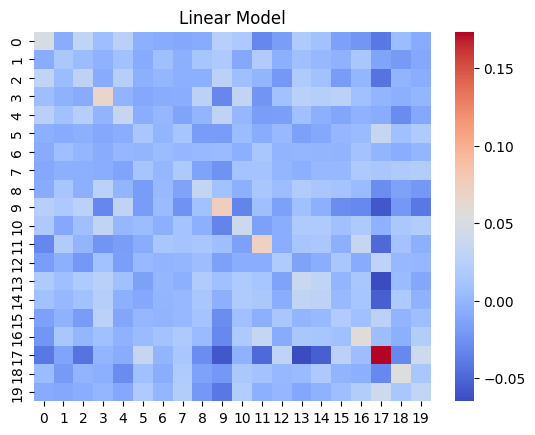

In [53]:
# Linear Model:
weight_heatmap(linear_model, cmap='coolwarm')
plt.title('Linear Model')
plt.show()

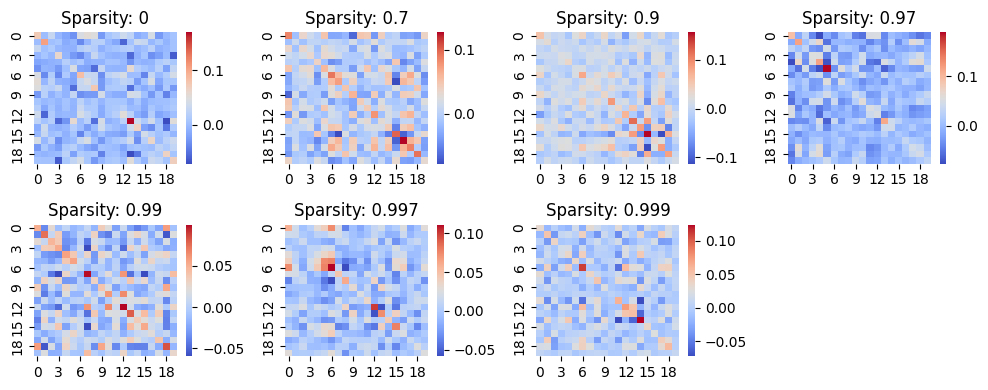

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4))
axes = axes.flatten()  # Convert 2D array to 1D for easy indexing

for i, (model, sparsity) in enumerate(zip(models, sparsity_values)):
    weight_heatmap(model, cmap='coolwarm', ax=axes[i])
    axes[i].set_title(f'Sparsity: {sparsity}')

# Hide the empty subplot
axes[7].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
def superposition():

The directory 'saved_models' exists.
